# Data cleanup notebook
This notebook is meant as both cleanup tool for the original dataset from [Zenodo](https://zenodo.org/record/5092309#.ZGumqxlByDQ) and as a documentation on what was changed if one uses already cleaned up dataset (most likely currently hosted privately on google cloud storage instance).

If using the notebook as cleanup tool, download original dataset fromm [Zenodo](https://zenodo.org/record/5092309#.ZGumqxlByDQ). You can optionally calculate the md5 checksum to verify that the data was downloaded without an error:
```bash
$ wget --output-document gwhd_2021.zip https://zenodo.org/record/5092309/files/gwhd_2021.zip?download=1 && uznip gwhd_2021.zip
$ python3 data_integrity.py <Path to the dataset> <original dataset MD5>
```
Then export environment variable **DATASET_ROOT_DIR** with path where the dataset was placed and then run this notebook. Remember to run the notebook from the terminal where **DATASET_ROOT_DIR** was exported!

If using this notebook as documentation, there is no need to run it as the data should already be cleaned up.

In [1]:
import os

print("Checking environment variables...")
assert 'PROJ_PATH' in os.environ
assert 'YOLOV7_ROOT_DIR' in os.environ
assert 'DATASET_MD5' in os.environ
assert 'ORIGINAL_DATASET_MD5' in os.environ
assert 'DATASET_ROOT_DIR' in os.environ
assert 'DATA_BUCKET' in os.environ
print("Environment variables exist.")

DATASET_ROOT_DIR = os.environ['DATASET_ROOT_DIR']

Checking environment variables...
Environment variables exist.


In [ ]:
from tqdm import tqdm
from PIL import Image

"""
All images in the dataset have .png extension, but some of them are actually .jpg files.
Convert them all to actuall .png files.
"""
images_dir = f'{DATASET_ROOT_DIR}/images'
for img_name in tqdm.tqdm(os.listdir(images_dir)):
    try:
        img = Image.open(img_name)
        img.save(img_name, format='PNG')
    except OSError:
        print(f"Couldn't convert {img_name}, skipping...")

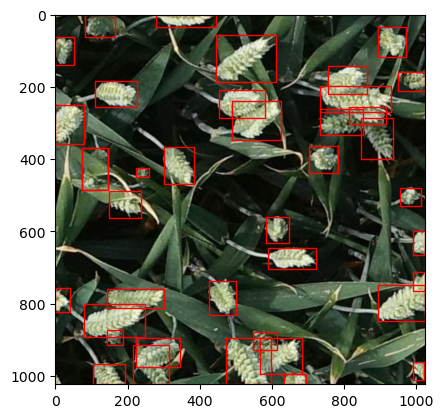

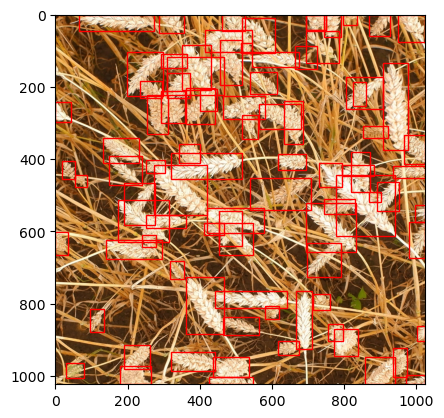

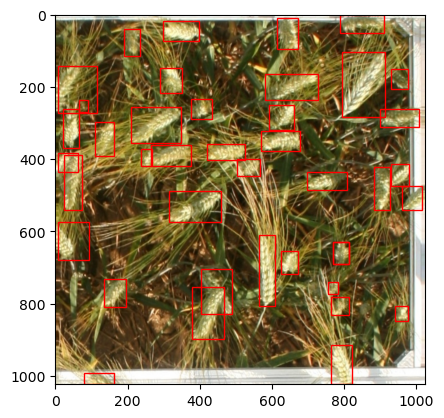

Could not load the image train/b11b3c68d79f4025ff7f542587ab91a67dfe55be69d1fb63db4bcbcb108284a9.png due to error: image file is truncated, skipping...


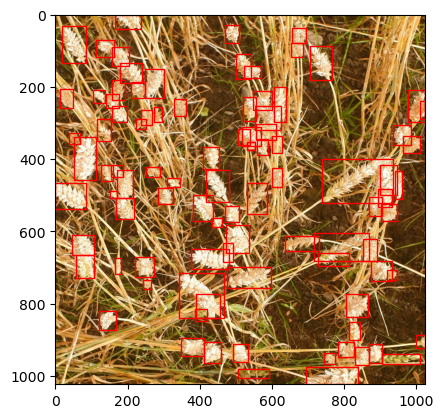

In [2]:
# Plot few images with bboxes that are throwing errors during yolo training
from gwhd_format_to_yolo import plot_bboxes

""" TODO
[Errno 17] File exists: '../../../../gwhd_2021/images/d88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.png' -> '../gwhd_2021/yolo-format-dataset/images/train/d88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.png'
[Errno 17] File exists: '../../../../gwhd_2021/images/1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2b6a83094476e8edb5b.png' -> '../gwhd_2021/yolo-format-dataset/images/train/1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2b6a83094476e8edb5b.png'
[Errno 17] File exists: '../../../../gwhd_2021/images/da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b8285f6821aae1f4203.png' -> '../gwhd_2021/yolo-format-dataset/images/test/da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b8285f6821aae1f4203.png'
"""

corrupted_images_paths = [ # TODO: Use original dataset paths not yolo
    'train/502d5e4a8b89aeffaa6adf13e1215d27c2951230ab06a4fcb93732117196f124.png',
    'train/8b461a21b9b01c657d41dfdf35b3607a0ab920c2cb78184c6e523391f5f3d554.png',
    'train/9f697765bd41325baaf635d5389020270c4536200f97884928c014ac1d39ce12.png',
    'train/b11b3c68d79f4025ff7f542587ab91a67dfe55be69d1fb63db4bcbcb108284a9.png',
    'train/c1db9589b954aa1ef2b5bf065d09aba926e674679a553c6dd6bfd5d6ae81f86a.png'
]

yolo_dataset_root = os.path.join(DATASET_ROOT_DIR, 'yolo-format-dataset')

for img_path in corrupted_images_paths:
    img_full_path = os.path.join(yolo_dataset_root, 'images', img_path)
    try:
        img = plt.imread(img_full_path)
    except OSError as e:
        print(f"Could not load the image {img_path} due to error: {e}, skipping...")
        continue

    label_full_path = os.path.join(yolo_dataset_root, 'labels', img_path.split('.')[0] + '.txt')
    with open(label_full_path) as f:
        bboxes = []
        for line in f.readlines():
            bbox = line.split(' ')[1:]
            bbox = [float(i) for i in bbox]
            bboxes.append(bbox)
        plot_bboxes(img_path.split('/')[1], bboxes)
    plt.show()
